In [2]:
# %% [markdown]
# # PySpark Data Pipeline - Full Notebook
#
# Chuyển đổi pipeline Pandas sang PySpark, chạy trực tiếp trong notebook, hỗ trợ đọc file CSV & SQL Server.
#
# - Có hàm chuyển dict schema sang StructType.
# - Có hàm đọc file/query, cache dữ liệu.
# - Đầy đủ các bước test trên file thực tế.

# %% [code]
# 1. Cài đặt pyspark nếu chưa có

# %% [code]
# 2. Import & khởi tạo SparkSession
from pyspark.sql import SparkSession

from src.config import DB_DATABASE, DB_PASSWORD, DB_SERVER, DB_USERNAME

jdbc_jar = "file:///D:/DataLocal/lthnhung/Desktop/retail-recommendation-system/notebooks/mssql-jdbc-12.10.1.jre11.jar"

spark = (
    SparkSession.builder.appName("PySparkPipelineDemo")
    .config("spark.jars", jdbc_jar)
    .getOrCreate()
)
# Nếu cần đọc SQL Server thì truyền thêm driver .jar:
# spark = SparkSession.builder \
#     .appName("PySparkPipelineDemo") \
#     .config("spark.jars", "/path/to/sqljdbc42.jar") \
#     .getOrCreate()

# %% [code]
# 3. Hàm chuyển dict schema sang Spark StructType
from pyspark.sql.types import (
    StructType,
    StructField,
    IntegerType,
    FloatType,
    StringType,
    BooleanType,
    LongType,
    DoubleType,
)


def convert_type(typ):
    typ = typ.lower()
    if typ in ("int32", "int", "int16", "int8"):
        return IntegerType()
    elif typ in ("int64",):
        return LongType()
    elif typ in ("float32", "float", "float64", "double"):
        return FloatType()
    elif typ in ("bool", "boolean"):
        return BooleanType()
    elif typ in ("string", "str", "object"):
        return StringType()
    else:
        return StringType()


def dict_to_structtype(dict_schema):
    return StructType(
        [
            StructField(name, convert_type(typ), True)
            for name, typ in dict_schema.items()
        ]
    )


# %% [code]
# 4. Định nghĩa dict schema mẫu
SCHEMA = {
    "sku": {
        "Sku": "int32",
        "VendorId": "int32",
        "Item_id": "int8",
        "Dept": "int16",
        "Sdept": "int16",
        "Class": "int16",
        "Sclass": "int16",
        "IsPrivateLabel": "bool",
        "Created": "Int32",
    },
    "store_adjust": {"StoreId": "int32", "StoreIdBSC": "int32"},
    "transactions": {
        "StoreId": "int32",
        "Date": "int32",
        "Time": "int32",
        "Sku": "int32",
        "Sales": "float32",
        "CustomerId": "Int64",
        "MergedId": "int64",
    },
}

# %% [code]
# 5. Test chuyển schema sang StructType
sku_schema = dict_to_structtype(SCHEMA["sku"])
print(sku_schema.simpleString())

# %% [code]
# 6. Đọc file CSV bằng schema spark
csv_path = "./sku.csv"  # Thay bằng path thật nếu có file
try:
    df = spark.read.csv(csv_path, header=True, schema=sku_schema)
    df.show(5)
    df.printSchema()
except Exception as e:
    print("Không tìm thấy file hoặc lỗi đọc file:", e)


# %% [code]
# 7. Hàm đọc query từ file (nếu dùng)
def load_query(file_path, params=None):
    with open(file_path, "r", encoding="utf-8-sig") as file:
        sql = file.read()
    if params:
        sql = sql.format(**params)
    return sql


JDBC_URL = f"jdbc:sqlserver://{DB_SERVER}:1433;databaseName={DB_DATABASE};integratedSecurity=true"
JDBC_DRIVER = "com.microsoft.sqlserver.jdbc.SQLServerDriver"
# %% [code]
# 8. Đọc SQL Server table/query vào Spark DataFrame
# Tùy chỉnh biến dưới cho thực tế của bạn!


def read_sql_spark(spark, sql, url, driver):
    return (
        spark.read.format("jdbc")
        .option("url", url)
        .option("dbtable", f"({sql}) as tmp")
        .option("driver", driver)
        .option("authenticationScheme", "nativeAuthentication")
        .option("user", "SGCOOP\\lthnhung")
        .load()
    )


# %% [code]
# 9. Demo đọc bảng từ SQL Server vào DataFrame
# sql = "SELECT TOP 100 * FROM sku"
# df_sql = read_sql_spark(spark, sql, DB_USERNAME, DB_PASSWORD, JDBC_URL, JDBC_DRIVER)
# df_sql.show(5)
# df_sql.printSchema()

# %% [code]
# 10. Class Pipeline PySpark
from pathlib import Path


class SparkDataPipeline:
    def __init__(self, spark, query_paths, schema_dict, cache_dir):
        self.spark = spark
        self.query_paths = query_paths
        self.schema_dict = schema_dict
        self.cache_dir = Path(cache_dir)

    def _get_schema(self, name):
        return dict_to_structtype(self.schema_dict[name])

    def _load_or_query(self, name, params=None, postprocess=None, force=False):
        cache_path = self.cache_dir / f"{name}.csv"
        spark_schema = self._get_schema(name)
        if cache_path.exists() and not force:
            df = self.spark.read.csv(str(cache_path), header=True, schema=spark_schema)
            print(f"✅ Đã load cache {cache_path.name} ({df.count()} dòng)")
        else:
            sql = (
                load_query(self.query_paths[name], params)
                if self.query_paths
                else f"SELECT * FROM {name}"
            )
            df = read_sql_spark(self.spark, sql, JDBC_URL, JDBC_DRIVER)
            if postprocess:
                df = postprocess(df)
            cache_path.parent.mkdir(parents=True, exist_ok=True)
            df.write.csv(str(cache_path), header=True, mode="overwrite")
            print(f"💾 Đã query & cache {cache_path.name} ({df.count()} dòng)")
        return df

    def load_df(self, name, params=None, postprocess=None):
        return self._load_or_query(name, params, postprocess)

    def load_sku(self):
        return self._load_or_query("sku")

    def load_store_adjust(self):
        return self._load_or_query("store_adjust")

    def load_transactions(self, params, force_reload):
        return self._load_or_query("transactions", params=params, force=force_reload)


# %% [code]
# 11. Demo sử dụng pipeline với file CSV
pipeline = SparkDataPipeline(
    spark=spark,
    query_paths={},  # Để trống nếu chỉ đọc file csv
    schema_dict=SCHEMA,
    cache_dir=".",  # Lưu tại thư mục hiện tại
)

try:
    df_sku = pipeline.load_sku()
    df_sku.show(5)
except Exception as e:
    print("Demo pipeline CSV lỗi (nếu không có file 'sku.csv'):", e)

# %% [code]
# 12. Dừng SparkSession khi xong
spark.stop()

struct<Sku:int,VendorId:int,Item_id:int,Dept:int,Sdept:int,Class:int,Sclass:int,IsPrivateLabel:boolean,Created:int>
Không tìm thấy file hoặc lỗi đọc file: [PATH_NOT_FOUND] Path does not exist: file:/d:/DataLocal/lthnhung/Desktop/retail-recommendation-system/sku.csv. SQLSTATE: 42K03
Demo pipeline CSV lỗi (nếu không có file 'sku.csv'): An error occurred while calling o96.load.
: com.microsoft.sqlserver.jdbc.SQLServerException: The TCP/IP connection to the host 10.10.15.89 # SQL Server host/IP, port 1433 has failed. Error: "10.10.15.89 # SQL Server host/IP. Verify the connection properties. Make sure that an instance of SQL Server is running on the host and accepting TCP/IP connections at the port. Make sure that TCP connections to the port are not blocked by a firewall.".
	at com.microsoft.sqlserver.jdbc.SQLServerException.makeFromDriverError(SQLServerException.java:250)
	at com.microsoft.sqlserver.jdbc.SQLServerException.convertConnectExceptionToSQLServerException(SQLServerException.jav

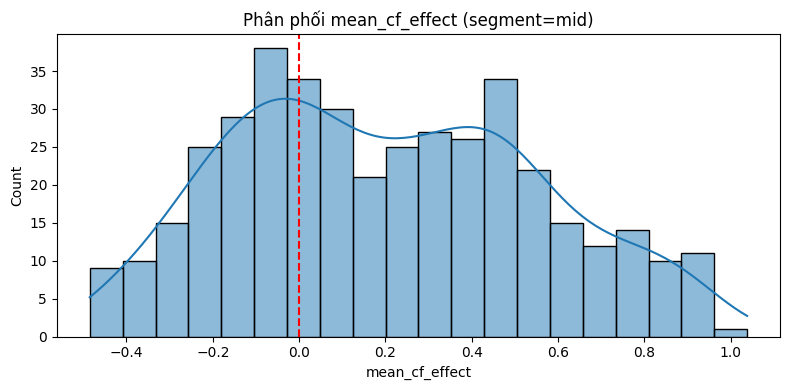

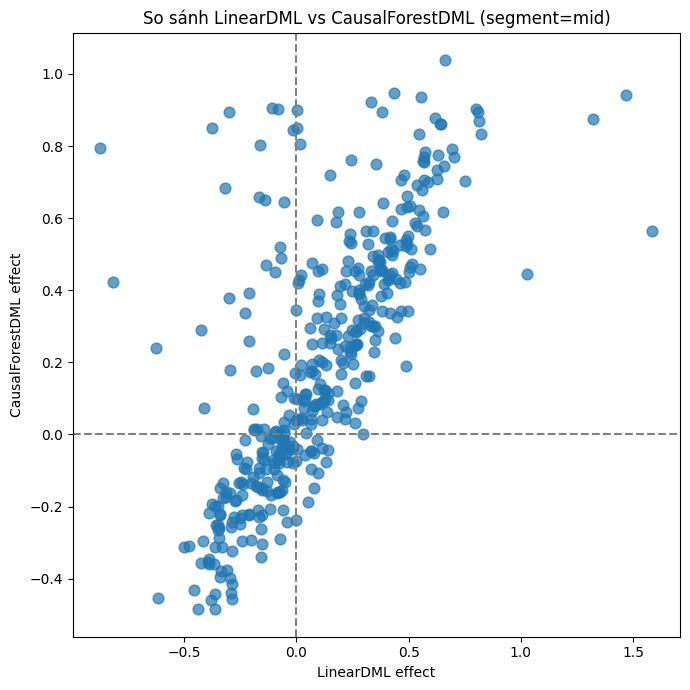

C:\Users\lthnhung\AppData\Local\Temp\ipykernel_19296\1102408989.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seg["abs_effect"] = df_seg["mean_cf_effect"].abs()


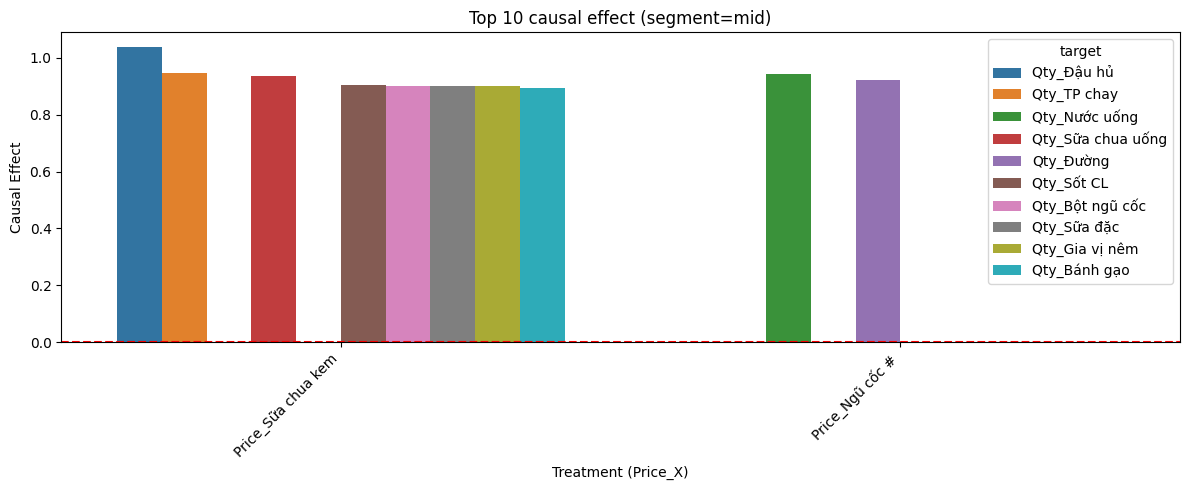

Quá nhiều nhóm, không vẽ heatmap!


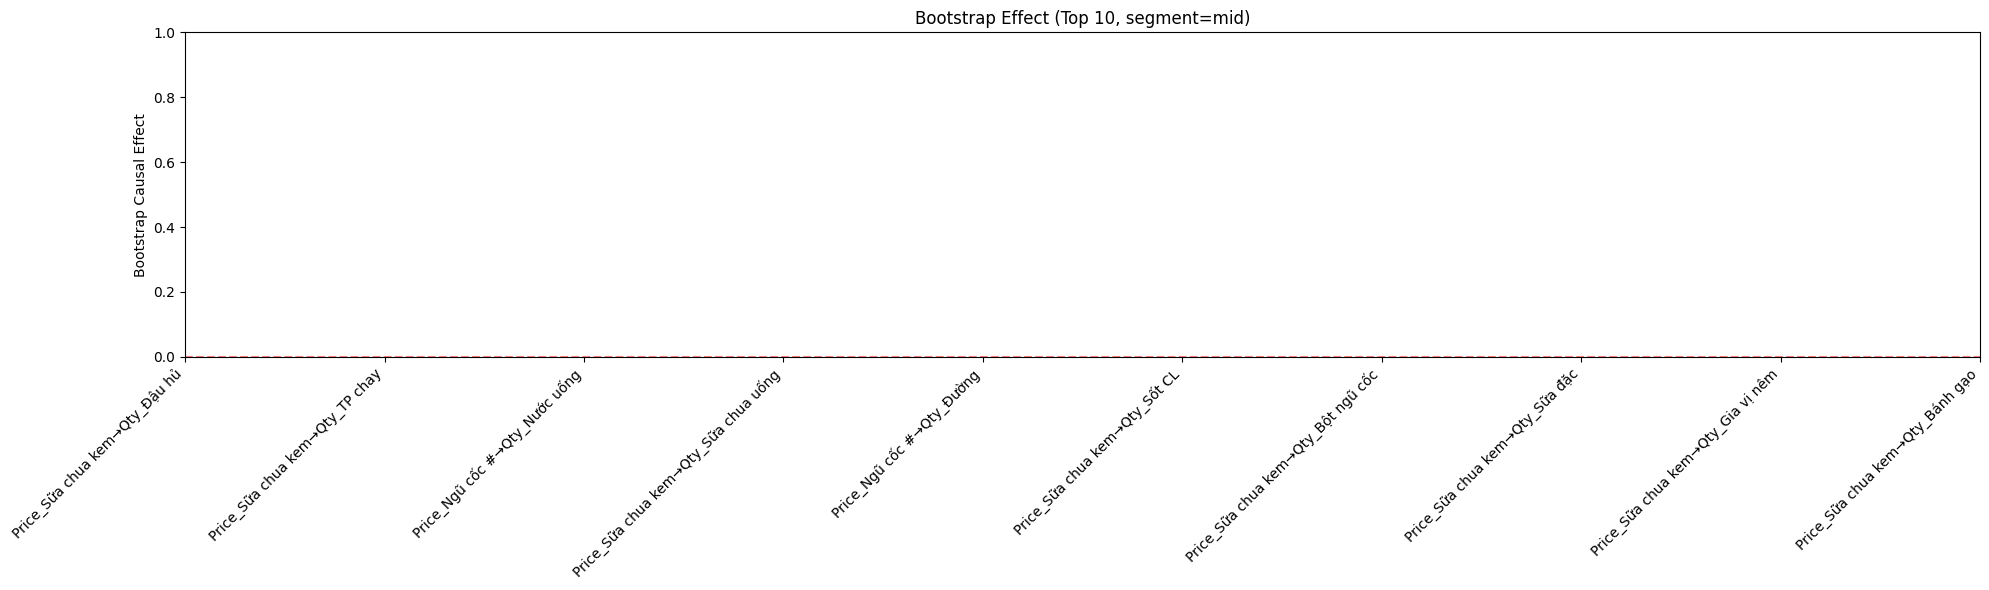

Vẽ xong! Xem các file hình PNG ở thư mục hiện tại.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast

from src.config import PROCESSED_DATA_DIR

# Đọc file kết quả causal effect
df = pd.read_csv(PROCESSED_DATA_DIR / "causal_effect_results.csv")

# ==== 1. Histogram phân phối causal effect (segment "mid") ====
segment = "mid"
df_seg = df[df["segment"] == segment]

plt.figure(figsize=(8, 4))
sns.histplot(df_seg["mean_cf_effect"].dropna(), bins=20, kde=True)
plt.axvline(0, color="red", ls="--")
plt.title(f"Phân phối mean_cf_effect (segment={segment})")
plt.xlabel("mean_cf_effect")
plt.tight_layout()
plt.savefig("hist_causal_effect.png")
plt.show()

# ==== 2. Scatterplot so sánh estimator ====
plt.figure(figsize=(7, 7))
plt.scatter(df_seg["mean_dml_effect"], df_seg["mean_cf_effect"], alpha=0.7, s=60)
plt.axhline(0, color="grey", ls="--")
plt.axvline(0, color="grey", ls="--")
plt.xlabel("LinearDML effect")
plt.ylabel("CausalForestDML effect")
plt.title(f"So sánh LinearDML vs CausalForestDML (segment={segment})")
plt.tight_layout()
plt.savefig("scatter_dml_vs_cf.png")
plt.show()

# ==== 3. Barplot top-N effect mạnh nhất ====
top_n = 10
df_seg["abs_effect"] = df_seg["mean_cf_effect"].abs()
df_top = df_seg.sort_values("abs_effect", ascending=False).head(top_n)
plt.figure(figsize=(12, 5))
sns.barplot(data=df_top, x="treatment", y="mean_cf_effect", hue="target")
plt.axhline(0, color="red", ls="--")
plt.title(f"Top {top_n} causal effect (segment={segment})")
plt.xlabel("Treatment (Price_X)")
plt.ylabel("Causal Effect")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("bar_top_effect.png")
plt.show()

# ==== 4. Heatmap causal effect giữa các nhóm (nếu ít nhóm) ====
if df_seg["treatment"].nunique() <= 40 and df_seg["target"].nunique() <= 40:
    pivot = df_seg.pivot(index="treatment", columns="target", values="mean_cf_effect")
    plt.figure(figsize=(1 + 0.5 * len(pivot.columns), 1 + 0.4 * len(pivot.index)))
    sns.heatmap(
        pivot,
        annot=True,
        fmt=".2f",
        cmap="RdBu_r",
        center=0,
        linewidths=0.5,
        cbar_kws={"label": "Causal Effect"},
    )
    plt.title(f"Causal Effect Heatmap (segment: {segment})")
    plt.ylabel("Treatment (Price_X)")
    plt.xlabel("Target (Qty_Y)")
    plt.tight_layout()
    plt.savefig("heatmap_causal_effect.png")
    plt.show()
else:
    print("Quá nhiều nhóm, không vẽ heatmap!")

# ==== 5. Boxplot bootstrap effect cho top effect (nếu có cột bootstrap_samples) ====
if "bootstrap_samples" in df_seg.columns:
    # Nếu bootstrap_samples lưu dạng chuỗi, cần chuyển thành list float
    def parse_bootstrap(s):
        if isinstance(s, str):
            try:
                return ast.literal_eval(s)
            except:
                return []
        return s

    df_top["bootstrap_samples"] = df_top["bootstrap_samples"].apply(parse_bootstrap)
    plt.figure(figsize=(2 * top_n, 6))
    bplot_data = [row for row in df_top["bootstrap_samples"]]
    labels = [f"{row['treatment']}→{row['target']}" for _, row in df_top.iterrows()]
    sns.boxplot(data=bplot_data)
    plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45, ha="right")
    plt.axhline(0, ls="--", color="red", alpha=0.5)
    plt.ylabel("Bootstrap Causal Effect")
    plt.title(f"Bootstrap Effect (Top {top_n}, segment={segment})")
    plt.tight_layout()
    plt.savefig("boxplot_bootstrap_top_effect.png")
    plt.show()
else:
    print("Không có cột bootstrap_samples, bỏ qua boxplot.")

print("Vẽ xong! Xem các file hình PNG ở thư mục hiện tại.")